### Setting Up the Environment

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# Function to set the seed for reproducibility
import random
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

# Set the seed
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Loading the Dataset

In [10]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

### Implementing a Variational Autoencoder

Let’s break down the internal structure step-by-step. The VAE can be divided into three main components: **Encoder**, **Reparameterize**, and **Decoder**.

#### Encoder:

- `fc1`: A fully connected layer that transforms the input into a hidden representation.
- `fc2_mean` and `fc2_logvar`: Fully connected layers that generate the mean and log variance of the latent space distribution.

#### Reparameterization Trick:

- `reparameterize` function: Uses the mean and log variance to sample from a Gaussian distribution to generate the latent variable z. This allows gradients to be backpropagated through the sampling process.

#### Decoder:

- `fc3` and `fc4`: Fully connected layers that reconstruct the input data from the latent variable z.
- Notably, the final activation function is a sigmoid, ensuring the output values range between 0 and 1.

It’s important to note that the size of the latent variable is not specified here but is left as a variable. The latent_dim is set when the model is instantiated. For initial experiments, we'll set it to 2 dimensions for easier visualization.

In [5]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(28 * 28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean of latent variables
        self.fc22 = nn.Linear(400, latent_dim)  # Log-variance of latent variables
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28 * 28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


### Training the VAE

Now let’s train the neural network we implemented above. We’ll start by defining the loss function and then follow the standard PyTorch training procedure.

#### Loss Function
The loss function of a VAE consists of two main components:

1. Reconstruction Loss: Measures how well the output matches the input.
2. Latent Space Regularization Loss: Ensures the latent space follows a standard normal distribution.

It is trained to simultaneously reduce the reconstruction loss and the latent space regularization loss. This means it not only reconstructs well but also follows a normal distribution in the latent space configuration.

In [6]:
# Loss function
beta = 1.0 
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta*KLD

### Training Loop

In [11]:
# Training the VAE with 2D latent space
latent_dim = 2
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, _ in trainloader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data) ##
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(trainloader.dataset)}')

Epoch 1, Loss: 202.17052259114584
Epoch 2, Loss: 173.53509334309896
Epoch 3, Loss: 166.700269140625
Epoch 4, Loss: 163.70557413736978
Epoch 5, Loss: 161.65591774088543
Epoch 6, Loss: 160.11090478515624
Epoch 7, Loss: 158.87642267252605
Epoch 8, Loss: 157.91102132161458
Epoch 9, Loss: 157.05264464518228
Epoch 10, Loss: 156.30643673502604
Epoch 11, Loss: 155.64546803385417
Epoch 12, Loss: 155.14519174804687
Epoch 13, Loss: 154.57787565104167
Epoch 14, Loss: 154.10667140299478
Epoch 15, Loss: 153.72446142578124
Epoch 16, Loss: 153.3468822265625
Epoch 17, Loss: 152.99192361653647
Epoch 18, Loss: 152.6211510904948
Epoch 19, Loss: 152.32845146484374
Epoch 20, Loss: 152.07368958333333
Epoch 21, Loss: 151.7544329752604
Epoch 22, Loss: 151.45453188476563
Epoch 23, Loss: 151.21821184895833
Epoch 24, Loss: 150.9772299641927
Epoch 25, Loss: 150.69705602213543
Epoch 26, Loss: 150.47038006184897
Epoch 27, Loss: 150.3127276529948
Epoch 28, Loss: 150.08010668945312
Epoch 29, Loss: 149.88121790364585
E

### Reconstructed Image Visualization

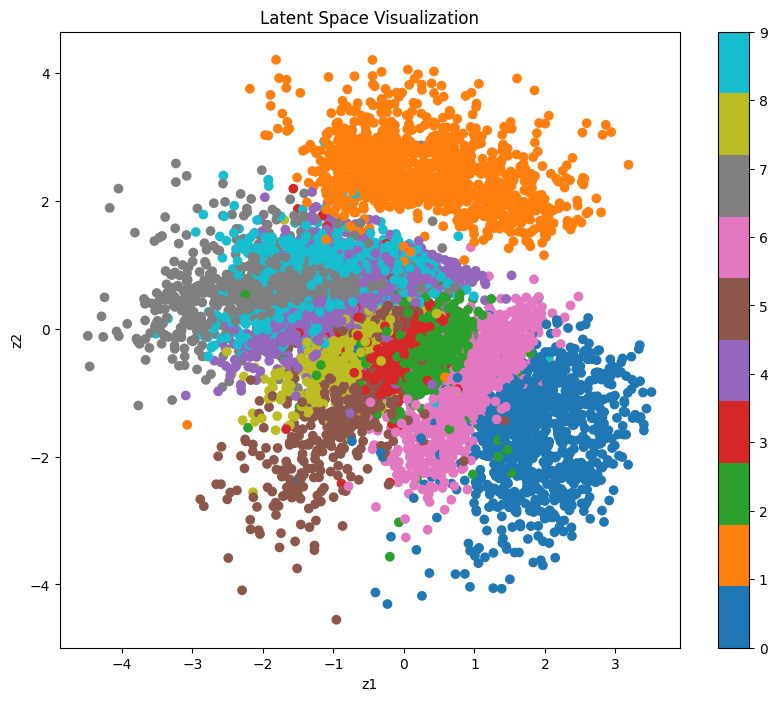

In [12]:
# Visualizing the latent space
model.eval()
all_z = []
all_labels = []
with torch.no_grad():
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=64, shuffle=False)

    for data, labels in testloader:
        data = data.to(device)
        mu, logvar = model.encode(data.view(-1, 28 * 28))
        z = model.reparameterize(mu, logvar)
        z = z.cpu().numpy()

        all_z.append(z)
        all_labels.append(labels)

    all_z = np.concatenate(all_z)
    all_labels = np.concatenate(all_labels)

    plt.figure(figsize=(10, 8))
    plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10')
    plt.colorbar()
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space Visualization')
    plt.show()

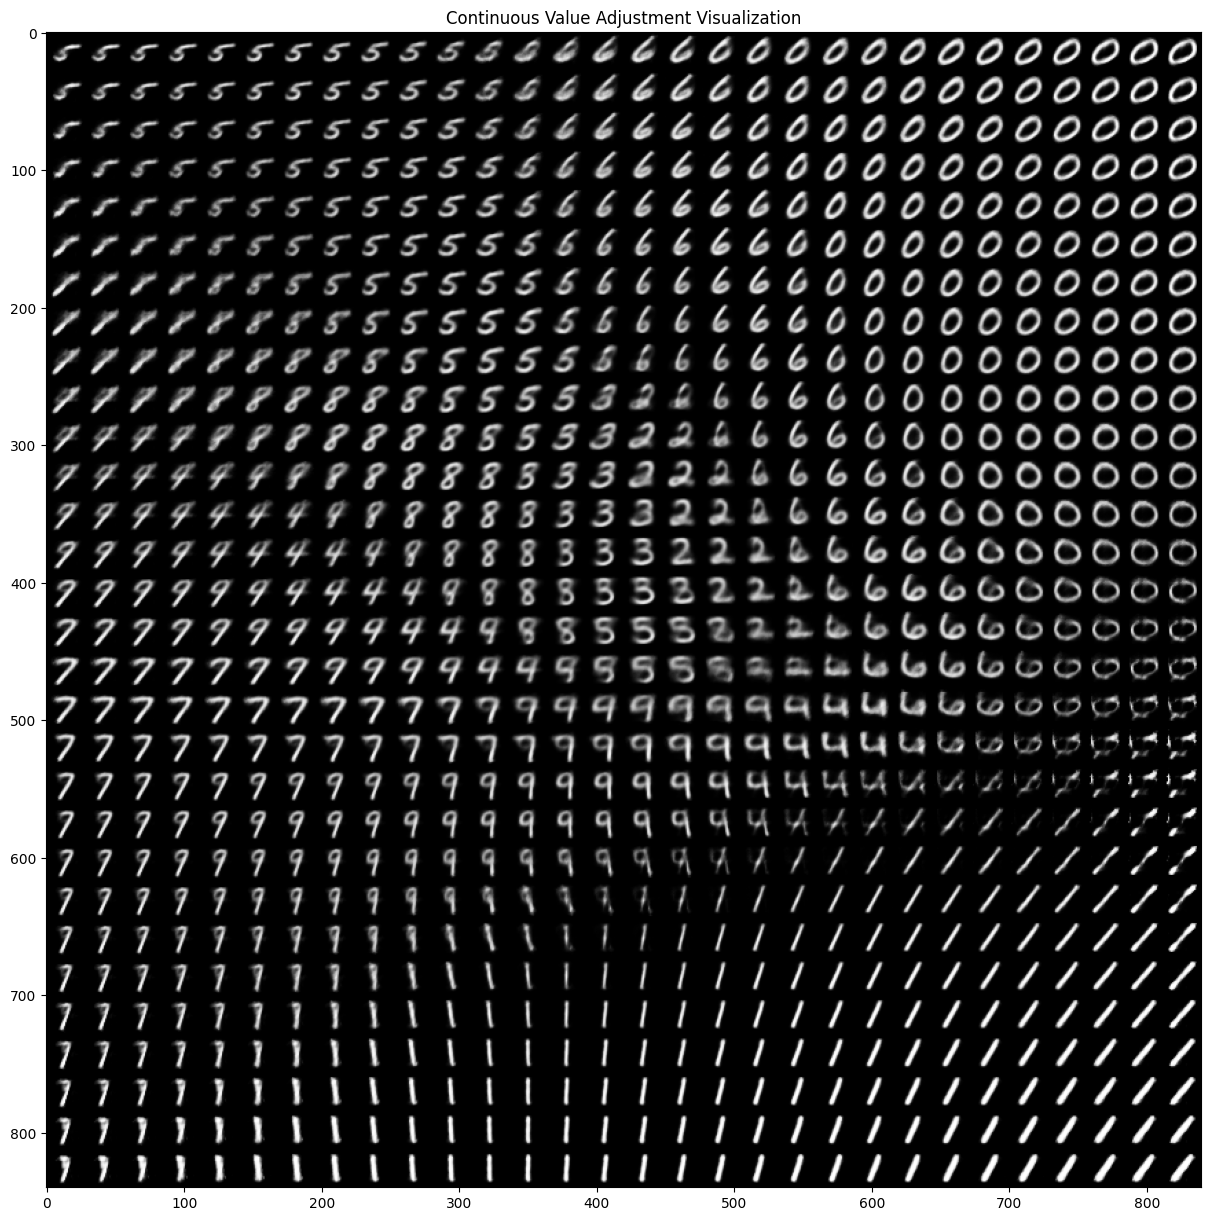

In [13]:
# Continuous value adjustment visualization
with torch.no_grad():
    grid_x = np.linspace(-3, 3, 30)
    grid_y = np.linspace(-3, 3, 30)
    figure = np.zeros((28 * 30, 28 * 30))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = torch.Tensor([[xi, yi]]).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded.view(28, 28).cpu().numpy()
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

    plt.figure(figsize=(15, 15))
    plt.imshow(figure, cmap='gray')
    plt.title('Continuous Value Adjustment Visualization')
    plt.show()

### Reconstruction Error as Anomaly Detection

In [14]:
# Function to calculate reconstruction error for a given input matrix
def calculate_reconstruction_error(model, input_matrix):
    model.eval()
    with torch.no_grad():
        # Convert the input matrix to a tensor and move to device
        input_tensor = torch.tensor(input_matrix, dtype=torch.float32).to(device).view(-1, 28 * 28)
        
        # Pass through the VAE to get the reconstructed output
        reconstructed, _, _ = model(input_tensor)
        
        # Calculate reconstruction error (mean squared error here)
        recon_error = F.mse_loss(reconstructed, input_tensor, reduction='sum').item()
    return recon_error

# Example: Calculate reconstruction error for a binary matrix (28x28)
# Randomly generated binary matrix (as an example anomaly input)
sample_binary_matrix = np.random.choice([0, 1], size=(28, 28)).astype(np.float32)
reconstruction_error = calculate_reconstruction_error(model, sample_binary_matrix)

print(f'Reconstruction error for the sample binary matrix: {reconstruction_error}')

Reconstruction error for the sample binary matrix: 338.1666564941406


In [20]:
# Dummy number one
number_one = np.zeros((28,28))
number_one[:,12:14] = 1

reconstruction_error = calculate_reconstruction_error(model, number_one)

print(f'Reconstruction error for the sample binary matrix: {reconstruction_error}')

Reconstruction error for the sample binary matrix: 91.27650451660156


Reconstruction error for a sampled MNIST digit: 41.76708984375


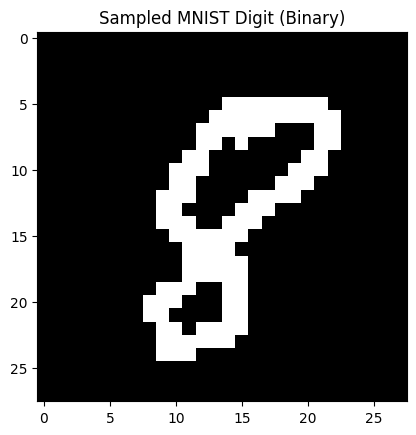

In [21]:
# Load MNIST test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=1, shuffle=True)

# Get a single sample digit from the test set
sample_data, _ = next(iter(testloader))
sample_data = sample_data.to(device)

# Convert the sample to a binary matrix (thresholding at 0.5)
sample_binary_matrix = (sample_data.squeeze().cpu().numpy() > 0.5).astype(np.float32)

# Calculate reconstruction error using the function
reconstruction_error = calculate_reconstruction_error(model, sample_binary_matrix)
print(f'Reconstruction error for a sampled MNIST digit: {reconstruction_error}')

# Plot the sampled binary digit for reference
plt.imshow(sample_binary_matrix, cmap='gray')
plt.title("Sampled MNIST Digit (Binary)")
plt.show()

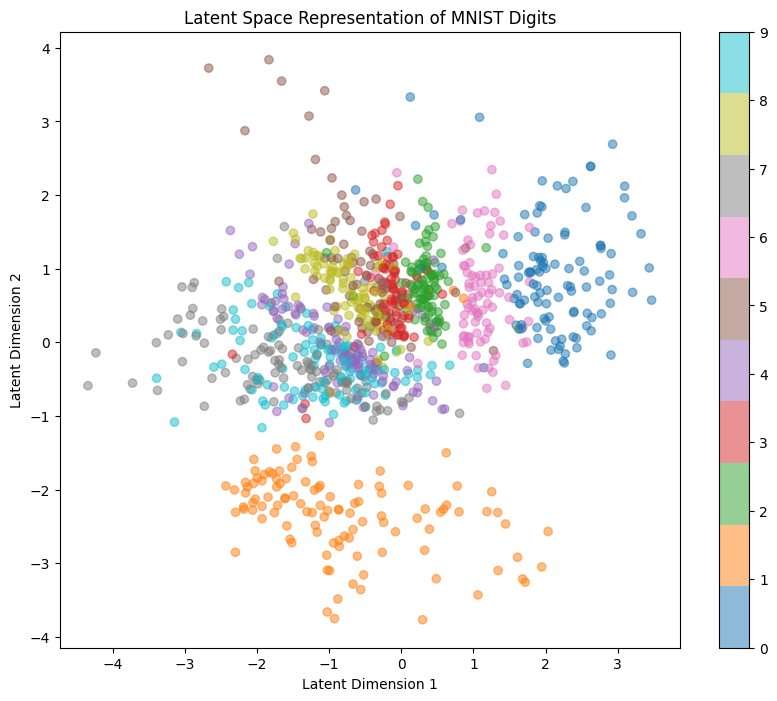

The sampled digit belongs to cluster 3


In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Function to visualize latent space
def visualize_latent_space(model, data_loader, num_samples=1000):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for i, (data, target) in enumerate(data_loader):
            if i * data_loader.batch_size >= num_samples:
                break
            data = data.to(device)
            mu, logvar = model.encode(data.view(-1, 28 * 28))
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())
            labels.extend(target.cpu().numpy())

    # Convert to numpy arrays
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.array(labels)

    # Plot latent space
    plt.figure(figsize=(10, 8))
    plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap="tab10", alpha=0.5)
    plt.colorbar()
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Representation of MNIST Digits")
    plt.show()

    return latent_vectors, labels

# Apply clustering (e.g., k-means)
def cluster_latent_space(latent_vectors, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(latent_vectors)
    return kmeans

# Classify a new digit based on its position in latent space
def classify_digit(model, input_digit, kmeans):
    model.eval()
    with torch.no_grad():
        # Encode the digit into the latent space
        mu, logvar = model.encode(input_digit.view(-1, 28 * 28).to(device))
        z = model.reparameterize(mu, logvar).cpu().numpy()
        
        # Predict the cluster
        cluster_label = kmeans.predict(z)
    return cluster_label

# Visualize the latent space
latent_vectors, labels = visualize_latent_space(model, testloader)

# Cluster the latent space
kmeans = cluster_latent_space(latent_vectors)

# Test a sample digit from the test set for classification
sample_data, _ = next(iter(testloader))
sample_data = sample_data[0]  # Take one sample digit

# Classify the digit based on its latent space cluster
cluster_label = classify_digit(model, sample_data, kmeans)
print(f'The sampled digit belongs to cluster {cluster_label[0]}')

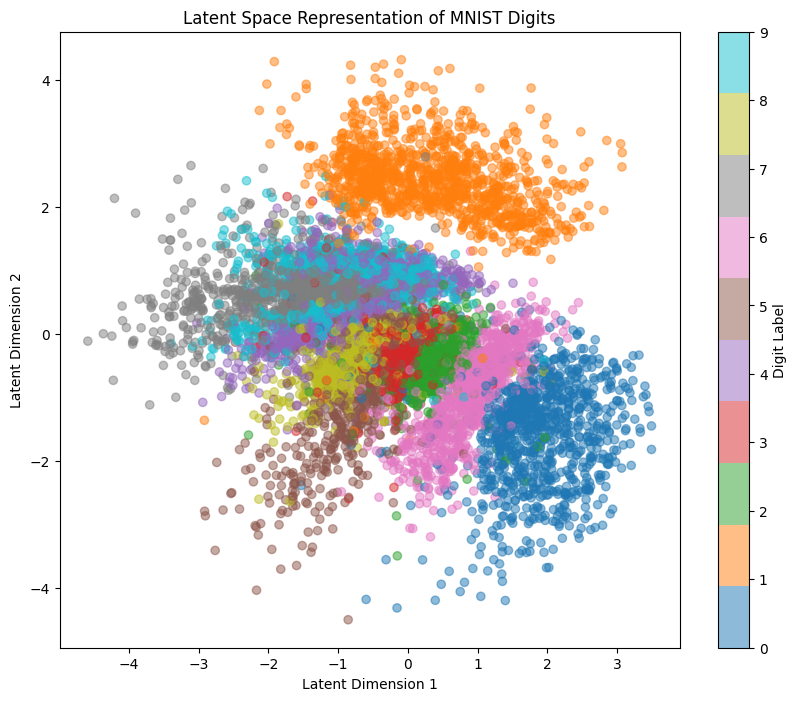

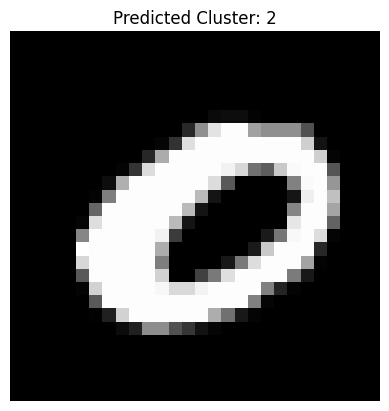

The sampled digit belongs to cluster 2


In [29]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Visualize the latent space function
def visualize_latent_space(model, data_loader, num_samples=20000):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for i, (data, target) in enumerate(data_loader):
            if i * data_loader.batch_size >= num_samples:
                break
            data = data.to(device)
            mu, logvar = model.encode(data.view(-1, 28 * 28))
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())
            labels.extend(target.cpu().numpy())

    # Convert to numpy arrays
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.array(labels)

    # Plot latent space
    plt.figure(figsize=(10, 8))
    plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap="tab10", alpha=0.5)
    plt.colorbar(label="Digit Label")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Representation of MNIST Digits")
    plt.show()

    return latent_vectors, labels

# Apply clustering (e.g., k-means)
def cluster_latent_space(latent_vectors, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(latent_vectors)
    return kmeans

# Classify a new digit based on its position in latent space and visualize the result
def classify_and_visualize_digit(model, input_digit, kmeans):
    model.eval()
    with torch.no_grad():
        # Encode the digit into the latent space
        mu, logvar = model.encode(input_digit.view(-1, 28 * 28).to(device))
        z = model.reparameterize(mu, logvar).cpu().numpy()
        
        # Predict the cluster
        cluster_label = kmeans.predict(z)[0]
    
    # Visualize the digit and its predicted cluster
    plt.imshow(input_digit.squeeze().cpu().numpy(), cmap="gray")
    plt.title(f"Predicted Cluster: {cluster_label}")
    plt.axis("off")
    plt.show()

    return cluster_label

# Visualize the latent space
latent_vectors, labels = visualize_latent_space(model, testloader)

# Cluster the latent space
kmeans = cluster_latent_space(latent_vectors)

# Test a sample digit from the test set for classification
sample_data, _ = next(iter(testloader))
sample_data = sample_data[0]  # Take one sample digit

# Classify the digit based on its latent space cluster and visualize
cluster_label = classify_and_visualize_digit(model, sample_data, kmeans)
print(f'The sampled digit belongs to cluster {cluster_label}')

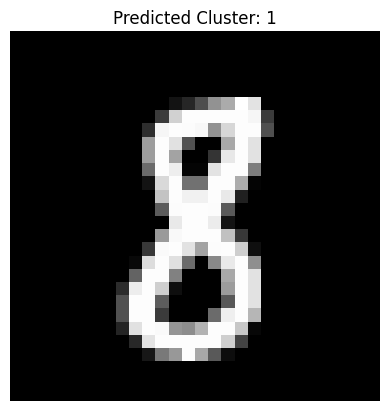

The sampled digit belongs to cluster 1


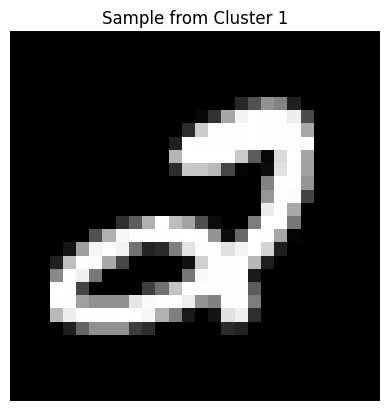

In [30]:
import random

# Function to find and visualize a sample from the same predicted cluster
def visualize_sample_from_cluster(model, data_loader, kmeans, target_cluster):
    model.eval()
    latent_vectors = []
    images = []

    # Encode all digits in the test set to find those in the same cluster
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            mu, logvar = model.encode(data.view(-1, 28 * 28))
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())
            images.extend(data.cpu().numpy())  # Store images for visualization

    # Convert to numpy arrays
    latent_vectors = np.concatenate(latent_vectors, axis=0)

    # Predict cluster labels for all latent vectors
    cluster_labels = kmeans.predict(latent_vectors)

    # Find indices of samples that belong to the target cluster
    target_indices = np.where(cluster_labels == target_cluster)[0]

    if len(target_indices) > 0:
        # Randomly select one sample from the target cluster
        sample_idx = random.choice(target_indices)
        sample_image = images[sample_idx].squeeze()

        # Visualize the sample
        plt.imshow(sample_image, cmap="gray")
        plt.title(f"Sample from Cluster {target_cluster}")
        plt.axis("off")
        plt.show()
    else:
        print(f"No samples found in cluster {target_cluster}.")

# Test a sample digit from the test set for classification
sample_data, _ = next(iter(testloader))
sample_data = sample_data[0]  # Take one sample digit

# Classify the digit based on its latent space cluster and visualize
cluster_label = classify_and_visualize_digit(model, sample_data, kmeans)
print(f'The sampled digit belongs to cluster {cluster_label}')

# Visualize a sample from the same predicted cluster
visualize_sample_from_cluster(model, testloader, kmeans, cluster_label)

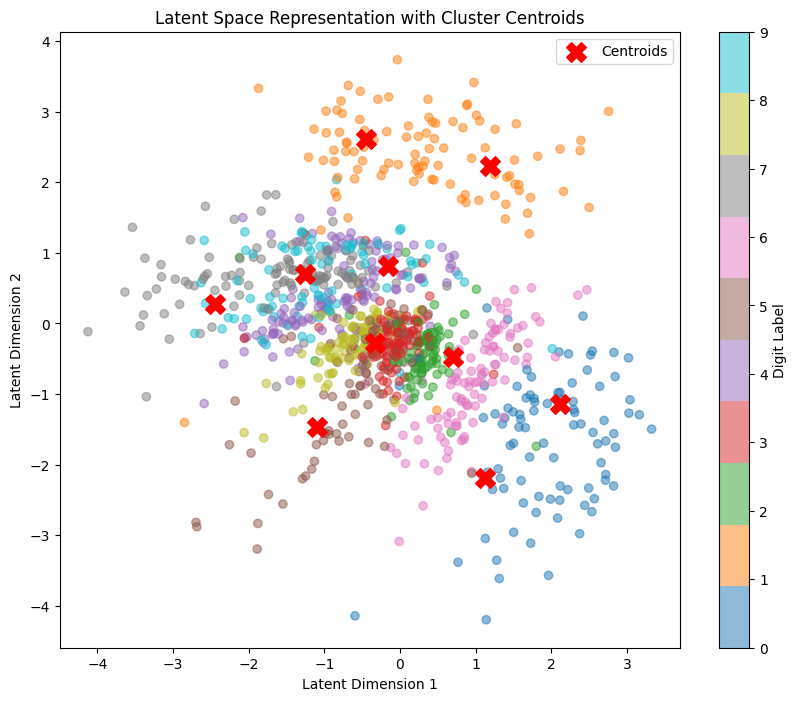

In [31]:
# Visualize the latent space with cluster centroids
def visualize_latent_space_with_centroids(model, data_loader, kmeans, num_samples=1000):
    model.eval()
    latent_vectors = []
    labels = []

    # Collect latent vectors and labels for visualization
    with torch.no_grad():
        for i, (data, target) in enumerate(data_loader):
            if i * data_loader.batch_size >= num_samples:
                break
            data = data.to(device)
            mu, logvar = model.encode(data.view(-1, 28 * 28))
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())
            labels.extend(target.cpu().numpy())

    # Convert to numpy arrays for plotting
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.array(labels)

    # Plot latent space with digit labels
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap="tab10", alpha=0.5)
    plt.colorbar(scatter, label="Digit Label")
    
    # Plot cluster centroids
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
    
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Representation with Cluster Centroids")
    plt.legend()
    plt.show()

# Visualize latent space with cluster centroids
visualize_latent_space_with_centroids(model, testloader, kmeans)